In [ ]:
import ee
import geemap
import xarray as xr

!pip install xee
import xee

In [2]:

# Authenticate Google Earth Engine
ee.Authenticate()

# Initialize Earth Engine (normally, you don't need to specify a project)
ee.Initialize()

# Create a map with a satellite basemap
Map = geemap.Map(basemap='SATELLITE')

# Display the map
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

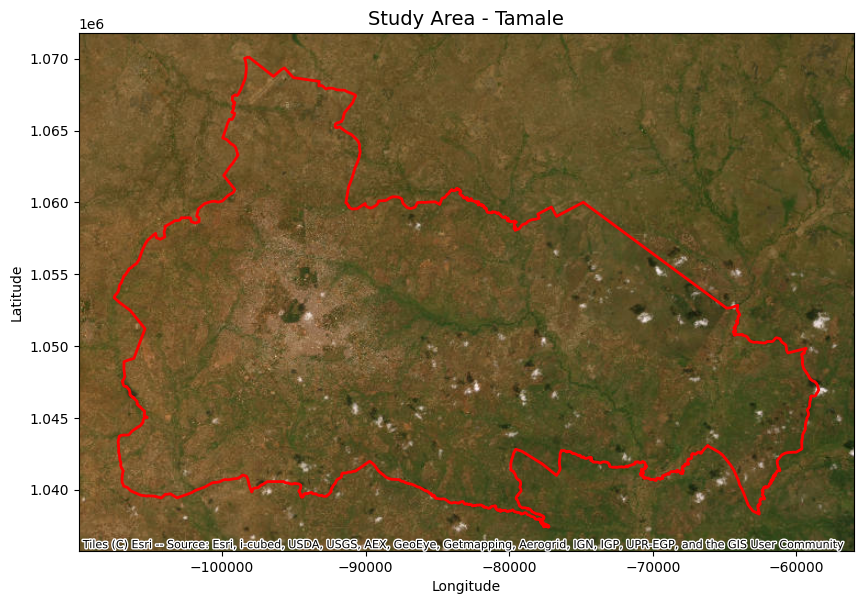

Map(center=[9.39620317973136, -0.7719820150787006], controls=(WidgetControl(options=['position', 'transparent_…

In [22]:
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For basemaps

# File path to shapefile
shapefile_path = r"C:\Users\DELL\Desktop\Ghana_New_260_District-shp (1)\Tamale.shp"

# Load shapefile for static plotting
study_area_gdf = gpd.read_file(shapefile_path)

# Convert shapefile to Earth Engine feature for interactive map
study_area_ee = geemap.shp_to_ee(shapefile_path)

# Create an interactive map using SATELLITE basemap
Map = geemap.Map(basemap='SATELLITE')
Map.addLayer(study_area_ee, {'color': 'red'}, 'Study Area')
Map.centerObject(study_area_ee, zoom=10)

# Convert to Web Mercator (needed for basemaps)
study_area_gdf = study_area_gdf.to_crs(epsg=3857)

# Plot the shapefile with the satellite basemap
fig, ax = plt.subplots(figsize=(10, 8))
study_area_gdf.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)

# Use ESRI Satellite Imagery for clearer basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Add title and labels
ax.set_title("Study Area - Tamale", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the static plot
plt.show()

# Display the interactive map
Map


In [4]:


# Authenticate & initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load the study area shapefile (ensure correct path)
shapefile_path = r"C:\Users\DELL\Desktop\Ghana_New_260_District-shp (1)\Tamale.shp"
study_area = geemap.shp_to_ee(shapefile_path)

# Load Landsat 5 Surface Reflectance Image Collection (1990-1995)
landsat = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
           .filterDate("1990-01-01", "1995-12-31")  # Filter by date range
           .filterBounds(study_area)  # Filter by study area
           .filter(ee.Filter.lt("CLOUD_COVER", 70))  # Keep images with less than 70% cloud cover
           .mosaic()  # Get the best available pixels
)

# Convert Surface Reflectance to Correct Scale
scaled = (landsat
          .select(['SR_B3', 'SR_B2', 'SR_B1'])  # Select RGB bands
          .multiply(0.0000275)  # Scale factor for surface reflectance
          .add(-0.2)  # Offset correction
)

# Clip the image to the study area
clippedImage = scaled.clip(study_area)

# Visualization parameters for Natural Color (321)
vis_params = {
    "bands": ["SR_B3", "SR_B2", "SR_B1"],  # True color bands (R-G-B)
    "min": 0.05,  # Adjusted minimum for better contrast
    "max": 0.19,  # Adjusted maximum for better brightness
    "gamma": 1.3  # Slight boost for visibility
}

# Create the map
Map = geemap.Map(basemap='SATELLITE')

# Add study area outline
Map.addLayer(study_area, {'color': 'red'}, "Study Area")

# Add the processed Landsat image
Map.addLayer(clippedImage, vis_params, "Landsat 1990-1995 (Natural Color)")

# Zoom to the study area
Map.centerObject(study_area, zoom=10)

# Display the map
Map


Map(center=[9.39620317973136, -0.7719820150787006], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Load Landsat 5 Level 1 Collection 2 Tier 1 Image Collection (1990-1995)
landsat = (ee.ImageCollection("LANDSAT/LT05/C02/T1")
          .filterDate("1990-01-01", "1995-12-31")
          .filterBounds(study_area)
          .filter(ee.Filter.lt("CLOUD_COVER", 70))
          .median())

# Thermal Band Processing
thermal_band = landsat.select("B6")
radiance = thermal_band.multiply(0.055376).add(1.2378)

# Brightness Temperature
K1 = 607.76
K2 = 1260.56
bt = radiance.expression(
    'K2 / log((K1 / L) + 1)', {
        'K1': K1,
        'K2': K2,
        'L': radiance
    }).rename('BT')

# NDVI Calculation
nir = landsat.select("B4")
red = landsat.select("B3")
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# Emissivity Calculation
emissivity = ndvi.expression(
    "(NDVI < 0.2) ? 0.985 : " +
    "((NDVI > 0.5) ? 0.99 : " + 
    "0.97 + 0.03 * ((NDVI - 0.2) / 0.3))", {
        'NDVI': ndvi  # Declare NDVI as a variable
    }
).rename('EM')

# LST Calculation
lambda_wavelength = 11.5e-6
c2 = 1.4388e-2
lst = bt.expression(
    '(BT * EM) / (1 + (lambda * BT / c2) * log(EM))', {
        'BT': bt,
        'EM': emissivity,
        'lambda': lambda_wavelength,
        'c2': c2
    }).rename('LST')

# Convert to Celsius
lst_celsius = lst.subtract(273.15).clip(study_area)

# Get Min and Max LST Values
min_lst = lst_celsius.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=study_area,
    scale=30,
    bestEffort=True
)
max_lst = lst_celsius.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=study_area,
    scale=30,
    bestEffort=True
)

print("Minimum LST (°C):", min_lst.getInfo())
print("Maximum LST (°C):", max_lst.getInfo())

# Visualization parameters
lst_vis = {
    "min": min_lst.getInfo()["LST"],  # Use actual min value
    "max": max_lst.getInfo()["LST"],  # Use actual max value
    "palette": [ "yellow", "orange", "red"]
}

# Create and display map

Map.centerObject(study_area, 10)
Map.addLayer(lst_celsius, lst_vis, "Land Surface Temperature (°C)")
Map.addLayer(study_area, {"color": "black"}, "Study Area")
Map

Minimum LST (°C): {'LST': 12.478440615392287}
Maximum LST (°C): {'LST': 22.622912610550713}


Map(center=[9.39620317973136, -0.7719820150787006], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
# Load Landsat 5 Level 1 Collection 2 Tier 1 Image Collection (1990-1995)
landsat = (ee.ImageCollection("LANDSAT/LT05/C02/T1")
          .filterDate("1990-01-01", "1995-12-31")
          .filterBounds(study_area)
          .filter(ee.Filter.lt("CLOUD_COVER", 70))
          .median())

# Select NIR (Band 4) and Red (Band 3) bands
nir = landsat.select("B4")
red = landsat.select("B3")

# Compute NDVI
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# Clip NDVI to the study area
ndvi_clipped = ndvi.clip(study_area)

# NDVI Visualization Parameters with Optimal Colors
ndvi_vis = {
    "min": -1,  # Minimum NDVI value
    "max": 1,   # Maximum NDVI value
    "palette":  ["#FF4500", "#FF8C00", "#FFD700", "#228B22", "#004d00"] # Deep red, gold, dark green
}

# Create and display map
Map = geemap.Map(basemap='SATELLITE')
Map.centerObject(study_area, 10)
Map.addLayer(ndvi_clipped, ndvi_vis, "NDVI (Clipped)")
Map.addLayer(study_area, {"color": "black"}, "Study Area")
Map

Map(center=[9.39620317973136, -0.7719820150787006], controls=(WidgetControl(options=['position', 'transparent_…

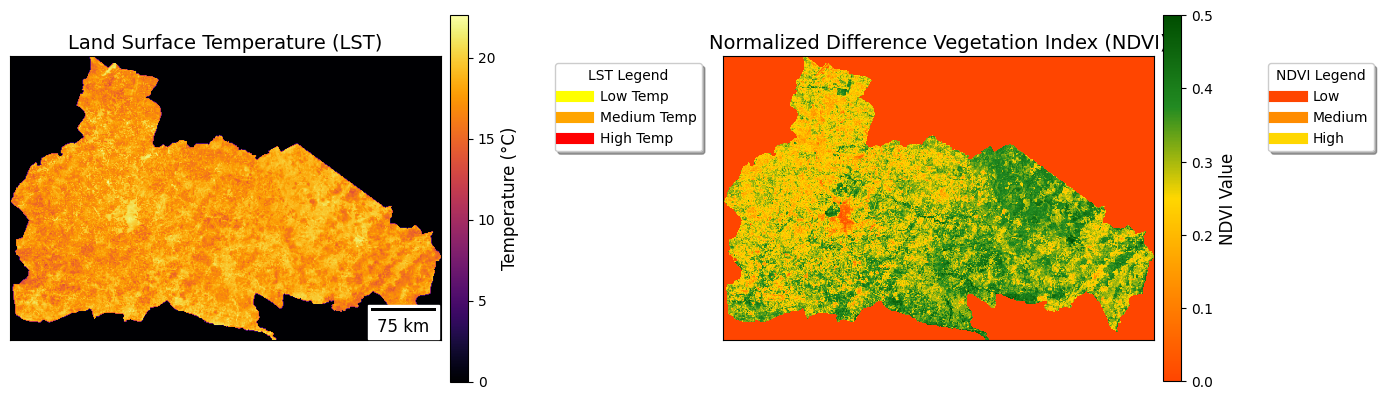

In [8]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar

# Initialize GEE
ee.Initialize()

# Use EE images and clip to study area
lst_img = lst_celsius.clip(study_area)
ndvi_img = ndvi.clip(study_area)

# Convert EE images to NumPy arrays (Higher resolution)
scale = 100  # High resolution for better quality
lst_array = geemap.ee_to_numpy(lst_img, region=study_area, scale=scale)
ndvi_array = geemap.ee_to_numpy(ndvi_img, region=study_area, scale=scale)

# Define Custom Color Maps
lst_cmap = mcolors.LinearSegmentedColormap.from_list("lst_cmap", ["yellow", "orange", "red"])
ndvi_cmap = mcolors.LinearSegmentedColormap.from_list("ndvi_cmap", 
                 ["#FF4500", "#FF8C00", "#FFD700", "#228B22", "#004d00"])  # Deep red, gold, dark green

# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), facecolor="white")  # White background

# --- LST Map ---
im1 = ax[0].imshow(lst_array, cmap="inferno")
ax[0].set_title("Land Surface Temperature (LST)", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_facecolor("white")  # Set background to black

# Add LST colorbar
cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.04, pad=0.02)
cbar1.set_label("Temperature (°C)", fontsize=12)

# --- NDVI Map ---
im2 = ax[1].imshow(ndvi_array, cmap=ndvi_cmap, vmin=0, vmax=0.5, interpolation="nearest")
ax[1].set_title("Normalized Difference Vegetation Index (NDVI)", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_facecolor("black") # Set background to black

# Add NDVI colorbar
cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.04, pad=0.02)
cbar2.set_label("NDVI Value", fontsize=12)

# --- Add Scale Bar ---
scalebar = ScaleBar(1, location="lower right", units="km", scale_loc="bottom",
                    font_properties={'size': 12})
ax[0].add_artist(scalebar)

# --- Add Grid ---
ax[0].grid(True, linestyle="--", alpha=0.3)
ax[1].grid(True, linestyle="--", alpha=0.3)

# --- Add NDVI Legend ---
ndvi_labels = [ "Low", "Medium", "High"]
ndvi_legend_patches = [plt.Line2D([0], [0], color=c, linewidth=8) 
                        for c in ["#FF4500", "#FF8C00", "#FFD700", "#228B22", "#004d00"]]
ax[1].legend(ndvi_legend_patches, ndvi_labels, title="NDVI Legend",
             loc="upper left", bbox_to_anchor=(1.25, 1), shadow=True, fontsize=10)

# --- Add LST Legend ---
lst_legend_patches = [plt.Line2D([0], [0], color="yellow", linewidth=8, label="Low Temp"),
                       plt.Line2D([0], [0], color="orange", linewidth=8, label="Medium Temp"),
                       plt.Line2D([0], [0], color="red", linewidth=8, label="High Temp")]
ax[0].legend(handles=lst_legend_patches, title="LST Legend",
             loc="upper left", bbox_to_anchor=(1.25, 1), shadow=True, fontsize=10)

# --- Final Layout Adjustments ---
plt.tight_layout()
plt.show()


LST Statistics: {'Mean': np.float64(9.777557322824405), 'Median': np.float64(15.878648437949352), 'Min': np.float64(0.0), 'Max': np.float64(22.62088444188197), 'Std Dev': np.float64(8.910563380965257)}
NDVI Statistics: {'Mean': np.float64(0.1624285914783674), 'Median': np.float64(0.20599250936329588), 'Min': np.float64(-0.04672897196261682), 'Max': np.float64(0.5175097276264592), 'Std Dev': np.float64(0.15501256330492086)}


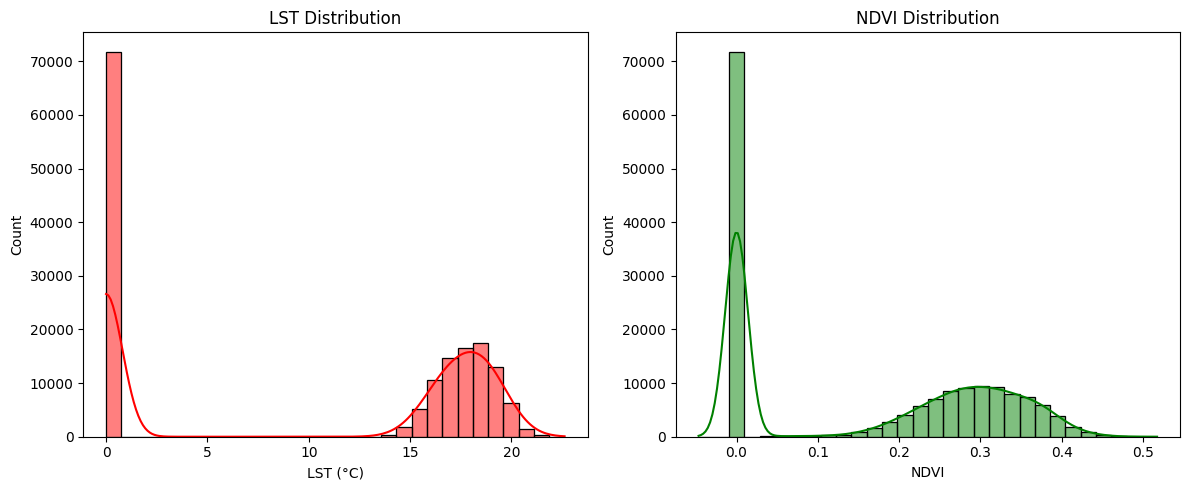

In [24]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Flatten arrays to 1D (Remove NaN values)
valid_mask = ~np.isnan(lst_array) & ~np.isnan(ndvi_array)  # Ensure no NaNs
lst_flat = lst_array[valid_mask].flatten()
ndvi_flat = ndvi_array[valid_mask].flatten()

# --- 1. Descriptive Statistics ---
lst_stats = {
    "Mean": np.mean(lst_flat),
    "Median": np.median(lst_flat),
    "Min": np.min(lst_flat),
    "Max": np.max(lst_flat),
    "Std Dev": np.std(lst_flat),
}

ndvi_stats = {
    "Mean": np.mean(ndvi_flat),
    "Median": np.median(ndvi_flat),
    "Min": np.min(ndvi_flat),
    "Max": np.max(ndvi_flat),
    "Std Dev": np.std(ndvi_flat),
}

print("LST Statistics:", lst_stats)
print("NDVI Statistics:", ndvi_stats)




# --- 5. Histogram of LST & NDVI ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(lst_flat, bins=30, kde=True, ax=axes[0], color="red")
axes[0].set_title("LST Distribution")
axes[0].set_xlabel("LST (°C)")

sns.histplot(ndvi_flat, bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("NDVI Distribution")
axes[1].set_xlabel("NDVI")

plt.tight_layout()
plt.show()



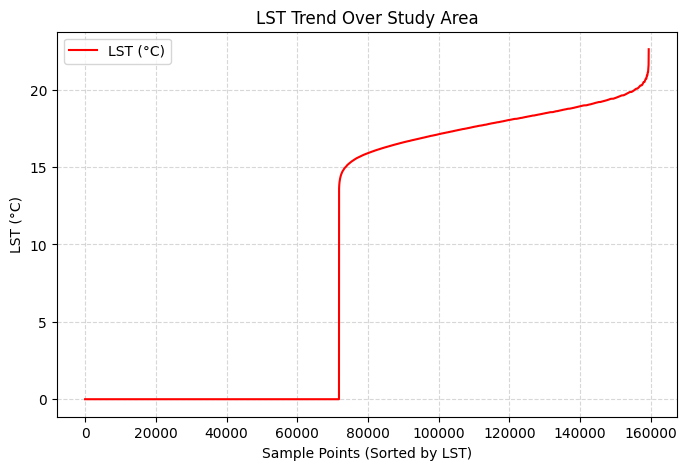

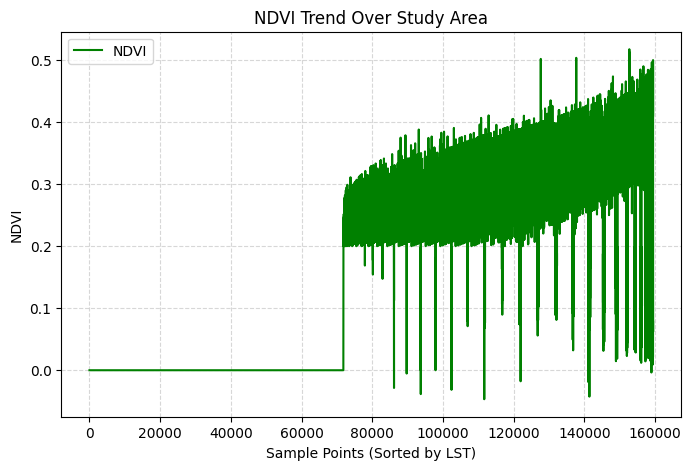

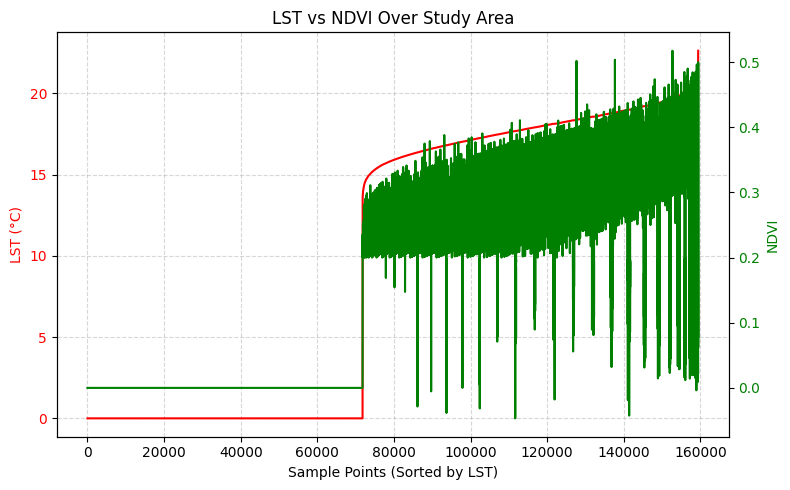

In [25]:

# Flatten arrays to 1D (Remove NaN values)
valid_mask = ~np.isnan(lst_array) & ~np.isnan(ndvi_array)  # Ensure no NaNs
lst_flat = lst_array[valid_mask].flatten()
ndvi_flat = ndvi_array[valid_mask].flatten()

# Sort values to create trend lines
sorted_indices = np.argsort(lst_flat)  # Sort based on LST
lst_sorted = lst_flat[sorted_indices]
ndvi_sorted = ndvi_flat[sorted_indices]

# --- 1. Line Graph: LST Trend ---
plt.figure(figsize=(8, 5))
plt.plot(lst_sorted, color="red", label="LST (°C)")
plt.xlabel("Sample Points (Sorted by LST)")
plt.ylabel("LST (°C)")
plt.title("LST Trend Over Study Area")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# --- 2. Line Graph: NDVI Trend ---
plt.figure(figsize=(8, 5))
plt.plot(ndvi_sorted, color="green", label="NDVI")
plt.xlabel("Sample Points (Sorted by LST)")
plt.ylabel("NDVI")
plt.title("NDVI Trend Over Study Area")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# --- 3. Combined Line Graph: LST & NDVI ---
fig, ax1 = plt.subplots(figsize=(8, 5))

# LST Line (Red)
ax1.plot(lst_sorted, color="red", label="LST (°C)")
ax1.set_xlabel("Sample Points (Sorted by LST)")
ax1.set_ylabel("LST (°C)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# NDVI Line (Green) - Secondary Y-Axis
ax2 = ax1.twinx()
ax2.plot(ndvi_sorted, color="green", label="NDVI")
ax2.set_ylabel("NDVI", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Title and Grid
plt.title("LST vs NDVI Over Study Area")
ax1.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()
